<h1>Predict the Introverts from the Extroverts
<h2>Playground Series - Season 5, Episode 7

<h2><u>Summary : 

<h4>
<ol> 
<li> Import of librairies & data
<li> Data exploration

<h2>1. Import of librairies & data

In [1]:
import pandas as pd
import numpy as np
import sklearn
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost

from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn import impute
from sklearn import tree

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer

print('Setup completed')

Setup completed


In [12]:
train = pd.read_csv('data/train.csv', index_col=['id'])
X_train = train.drop(columns=['Personality'],axis=1)
y_train = train.Personality
test = pd.read_csv('data/test.csv')

In [20]:
train.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           17334 non-null  float64
 1   Stage_fear                 16631 non-null  object 
 2   Social_event_attendance    17344 non-null  float64
 3   Going_outside              17058 non-null  float64
 4   Drained_after_socializing  17375 non-null  object 
 5   Friends_circle_size        17470 non-null  float64
 6   Post_frequency             17260 non-null  float64
 7   Personality                18524 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.3+ MB


In [14]:
train.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,3.137764,5.265106,4.044319,7.996737,4.982097
std,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,3.000000,5.000000,3.000000
50%,2.000000,5.000000,4.000000,8.000000,5.000000
75%,4.000000,8.000000,6.000000,12.000000,7.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


In [22]:
cat_f = ['StageFear', 'Drained_after_socializing']
num_f = ['Time_spent_Alone','Social_event_attendance','Going_outside','Friends_circle_size', 'Post_frequency' ]

In [19]:
train.isnull().sum()/train.shape[0]*100

Time_spent_Alone              6.424098
Stage_fear                   10.219175
Social_event_attendance       6.370114
Going_outside                 7.914057
Drained_after_socializing     6.202764
Friends_circle_size           5.689916
Post_frequency                6.823580
Personality                   0.000000
dtype: float64

We observe that there are a lot of missing values : between 5 to 10% according to the features. The imputation of these missing values will be one of the key work to prepare the values

We are going to analyze the distributions of the differents features.

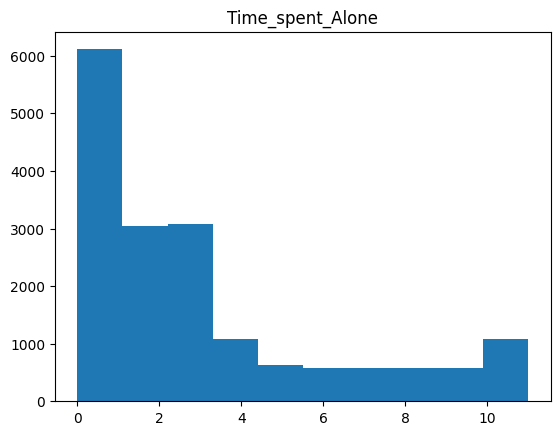

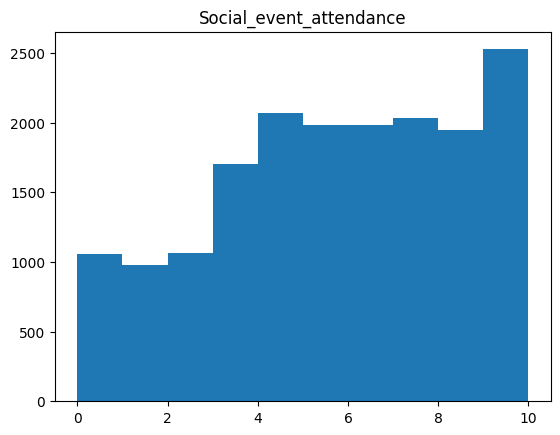

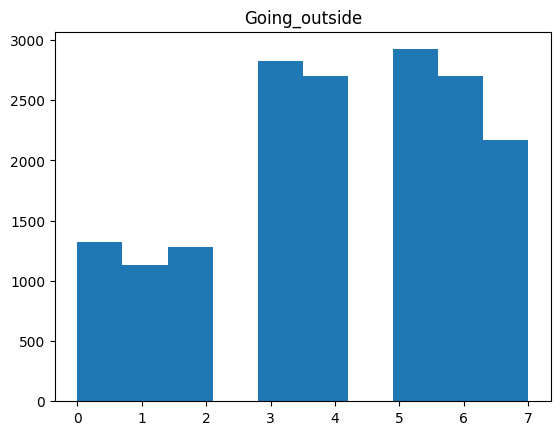

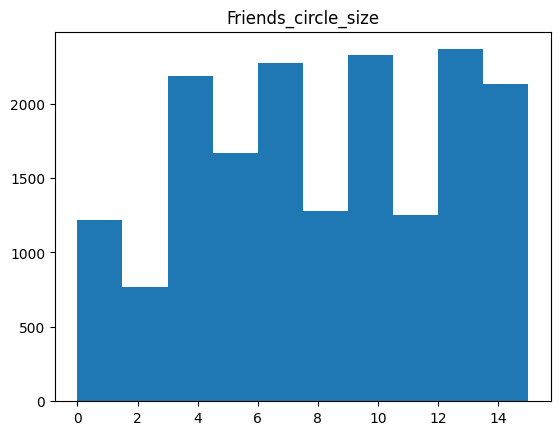

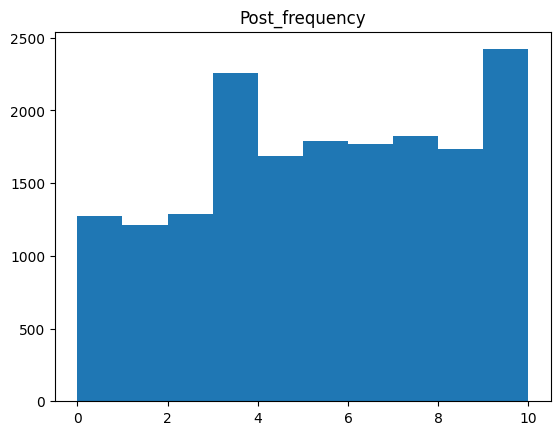

In [24]:
for i in num_f:
    plt.hist(train[i])
    plt.title(i)
    plt.show()

We may need to normalize some variables to have a distribution that looks more like a gaussian distribution.

                         Time_spent_Alone  Social_event_attendance  \
Time_spent_Alone                 1.000000                -0.628806   
Social_event_attendance         -0.628806                 1.000000   
Going_outside                   -0.640884                 0.585224   
Friends_circle_size             -0.598014                 0.566675   
Post_frequency                  -0.611544                 0.566679   

                         Going_outside  Friends_circle_size  Post_frequency  
Time_spent_Alone             -0.640884            -0.598014       -0.611544  
Social_event_attendance       0.585224             0.566675        0.566679  
Going_outside                 1.000000             0.549864        0.579305  
Friends_circle_size           0.549864             1.000000        0.522272  
Post_frequency                0.579305             0.522272        1.000000  


<Axes: >

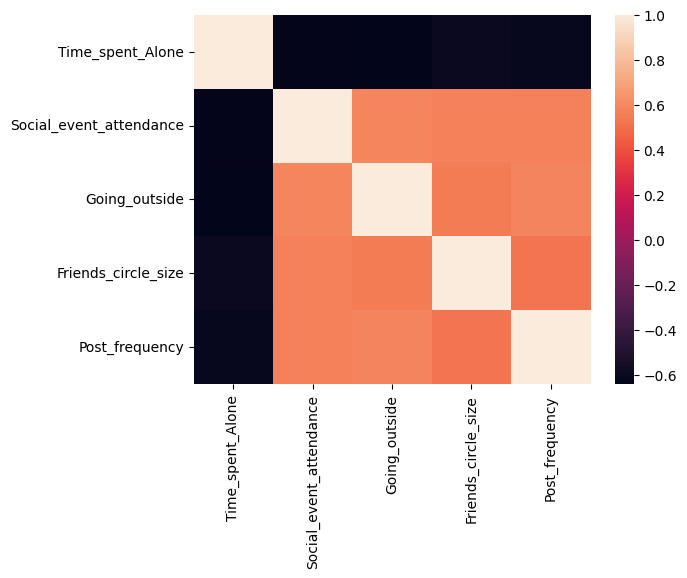

In [25]:
print(train[num_f].corr())
sns.heatmap(train[num_f].corr())

The 'Time_spent_Alone' feature seems to be quite interesting seeing that it seems higly inversed correlated with all the other features.